In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (256, 256)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    "C:\\Users\\farha\\Desktop\\Py\\Pencil_shading",
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=42    
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    "C:\\Users\\farha\\Desktop\\Py\\Pencil_shading",
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=42
)

Found 3061 files belonging to 5 classes.
Using 2449 files for training.
Found 3061 files belonging to 5 classes.
Using 612 files for validation.


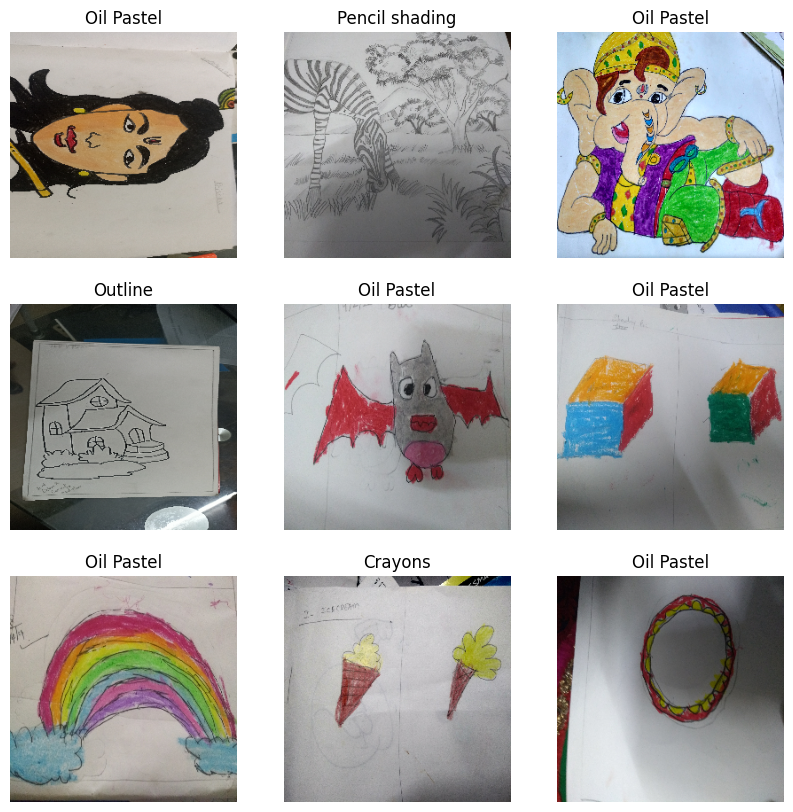

In [3]:
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [4]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 3)
validation_dataset = validation_dataset.skip(val_batches // 3)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 14
Number of test batches: 6


In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

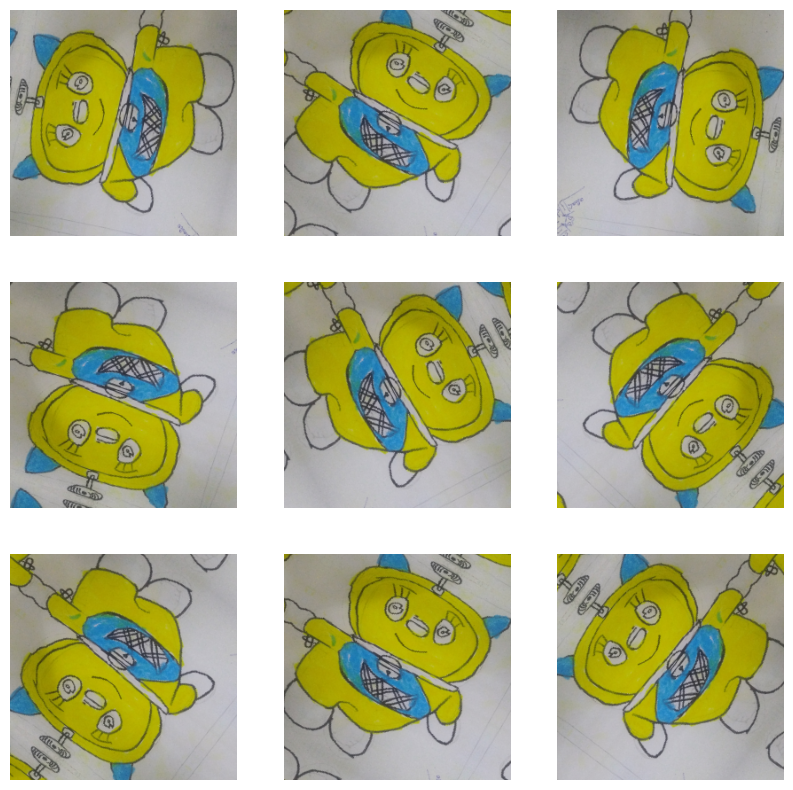

In [7]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0),training=True)
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [8]:
preprocess_input_resnet = tf.keras.applications.resnet50.preprocess_input
preprocess_input_inception = tf.keras.applications.inception_v3.preprocess_input

In [9]:
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False, 
    input_shape=(256, 256, 3))

In [10]:
base_model.trainable=False

In [11]:
model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(256,256,3)),
        data_augmentation,
        tf.keras.layers.Lambda(preprocess_input_resnet),
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                      

In [12]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset) 

Epoch 1/10
77/77 [==============================] - 55s 548ms/step - loss: nan - accuracy: 0.0482 - val_loss: nan - val_accuracy: 0.0429
Epoch 2/10
77/77 [==============================] - 44s 534ms/step - loss: nan - accuracy: 0.0453 - val_loss: nan - val_accuracy: 0.0452
Epoch 3/10
77/77 [==============================] - 43s 529ms/step - loss: nan - accuracy: 0.0453 - val_loss: nan - val_accuracy: 0.0381
Epoch 4/10
77/77 [==============================] - 43s 523ms/step - loss: nan - accuracy: 0.0453 - val_loss: nan - val_accuracy: 0.0333
Epoch 5/10
77/77 [==============================] - 43s 522ms/step - loss: nan - accuracy: 0.0453 - val_loss: nan - val_accuracy: 0.0381
Epoch 6/10
77/77 [==============================] - 43s 519ms/step - loss: nan - accuracy: 0.0453 - val_loss: nan - val_accuracy: 0.0333
Epoch 7/10
77/77 [==============================] - 43s 522ms/step - loss: nan - accuracy: 0.0453 - val_loss: nan - val_accuracy: 0.0333
Epoch 8/10
77/77 [=======================

In [13]:
model.save("ResNet.h5")